# Trabajo práctico Aprendizaje Automático 1

In [1]:
#Importamos las librerias
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("code")
current_dir = os.path.dirname(os.path.realpath('__file__'))
data_source = os.path.join(current_dir, 'data', 'weatherAUS.csv')

from cleaning.clean import Clean
from regresion_lineal.regresion import RegressionLineal
from shap_analyzer.shap_analyzer import SHAPAnalyzer
from modelo_base.regression import RegresionModelBase
from modelo_base.clasification import ClasificationModelBase
from neural_network.classification_neural import ClassificationNeuralNetwork
from neural_network.regression_neural import RegressionNeuralNetwork
from sklearn.model_selection import train_test_split


2024-02-24 17:11:38.118980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv(data_source)

# Análisis descriptivo

In [3]:
df.info()
# el dataset cuenta con un total de 145412 datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        145412 non-null  int64  
 1   Date              145412 non-null  object 
 2   Location          145412 non-null  object 
 3   MinTemp           143928 non-null  float64
 4   MaxTemp           144159 non-null  float64
 5   Rainfall          142152 non-null  float64
 6   Evaporation       82658 non-null   float64
 7   Sunshine          75616 non-null   float64
 8   WindGustDir       135096 non-null  object 
 9   WindGustSpeed     135159 non-null  float64
 10  WindDir9am        134850 non-null  object 
 11  WindDir3pm        141186 non-null  object 
 12  WindSpeed9am      143645 non-null  float64
 13  WindSpeed3pm      142351 non-null  float64
 14  Humidity9am       142759 non-null  float64
 15  Humidity3pm       140907 non-null  float64
 16  Pressure9am       13

In [4]:
# Filtramos por las ciudades de interés
ciudades = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df[df['Location'].isin(ciudades)]

In [5]:
# visualizamos los datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
30167,30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,6.0
30168,30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,6.6
30169,30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,18.8
30170,30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,77.4
30171,30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,1.6


In [6]:
# vemos los nombres de las columnas
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [7]:
# observamos la información de cada variable y si hay nulos
df.info()
"""
Contamos con un total de 15986 datos.
Tenemos 25 columnas, de las cuales 18 son variables numéricas, 1 es tipo int64 y 17 son tipo loat64. Las otras 7 son variables categóricas, tipo object.
"""

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 30167 to 70370
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        15986 non-null  int64  
 1   Date              15986 non-null  object 
 2   Location          15986 non-null  object 
 3   MinTemp           15495 non-null  float64
 4   MaxTemp           15500 non-null  float64
 5   Rainfall          15199 non-null  float64
 6   Evaporation       14280 non-null  float64
 7   Sunshine          14038 non-null  float64
 8   WindGustDir       14529 non-null  object 
 9   WindGustSpeed     14531 non-null  float64
 10  WindDir9am        15291 non-null  object 
 11  WindDir3pm        15696 non-null  object 
 12  WindSpeed9am      15725 non-null  float64
 13  WindSpeed3pm      15737 non-null  float64
 14  Humidity9am       15416 non-null  float64
 15  Humidity3pm       15461 non-null  float64
 16  Pressure9am       15251 non-null  float64

'\nContamos con un total de 15986 datos.\nTenemos 25 columnas, de las cuales 18 son variables numéricas, 1 es tipo int64 y 17 son tipo loat64. Las otras 7 son variables categóricas, tipo object.\n'

In [8]:
# Cantidad de valores faltantes.
df.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp              491
MaxTemp              486
Rainfall             787
Evaporation         1706
Sunshine            1948
WindGustDir         1457
WindGustSpeed       1455
WindDir9am           695
WindDir3pm           290
WindSpeed9am         261
WindSpeed3pm         249
Humidity9am          570
Humidity3pm          525
Pressure9am          735
Pressure3pm          726
Cloud9am            2677
Cloud3pm            2932
Temp9am              505
Temp3pm              496
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
dtype: int64

In [9]:
# Estadística descriptiva de las variables numéricas
df.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,15986.000000,15495.000000,15500.000000,15199.000000,14280.000000,14038.000000,14531.000000,15725.000000,15737.000000,15416.000000,15461.000000,15251.000000,15260.000000,13309.000000,13054.000000,15481.000000,15490.000000,15199.000000
mean,49512.619855,11.605221,21.751781,2.303744,4.866828,6.854694,44.417315,16.613672,21.797166,68.903023,51.280577,1018.305836,1016.064239,4.750545,4.746131,15.545953,20.229154,2.302586
std,15172.399796,5.851347,6.053679,7.385992,3.069869,3.842419,14.958027,10.336386,9.518033,15.614788,17.721335,7.400730,7.265386,2.728329,2.589879,5.559295,5.857956,7.385251
min,30176.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,34173.250000,7.900000,17.100000,0.000000,2.600000,3.700000,33.000000,9.000000,15.000000,59.000000,39.000000,1013.400000,1011.200000,2.000000,2.000000,11.600000,15.900000,0.000000
50%,47228.500000,11.600000,21.300000,0.000000,4.200000,7.500000,43.000000,15.000000,20.000000,70.000000,51.000000,1018.500000,1016.300000,6.000000,6.000000,15.400000,19.800000,0.000000
75%,66393.750000,15.800000,25.800000,0.800000,6.600000,10.000000,54.000000,22.000000,28.000000,80.000000,62.000000,1023.300000,1021.000000,7.000000,7.000000,19.500000,24.100000,0.800000
max,70391.000000,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,119.400000


### Analizamos nuestra variable objetivo, la que queremos predecir para saber si el df esta balanceado o no.

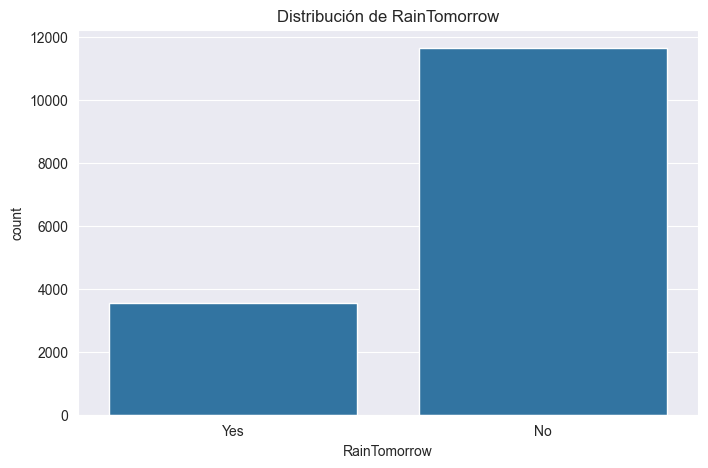

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='RainTomorrow', data=df)
plt.title('Distribución de RainTomorrow')
plt.show()

### Se puede observar que el dataset no esta balanceado, con esto podemos decir que nos va a predecir mejor cuando no llueve que cuando llueve

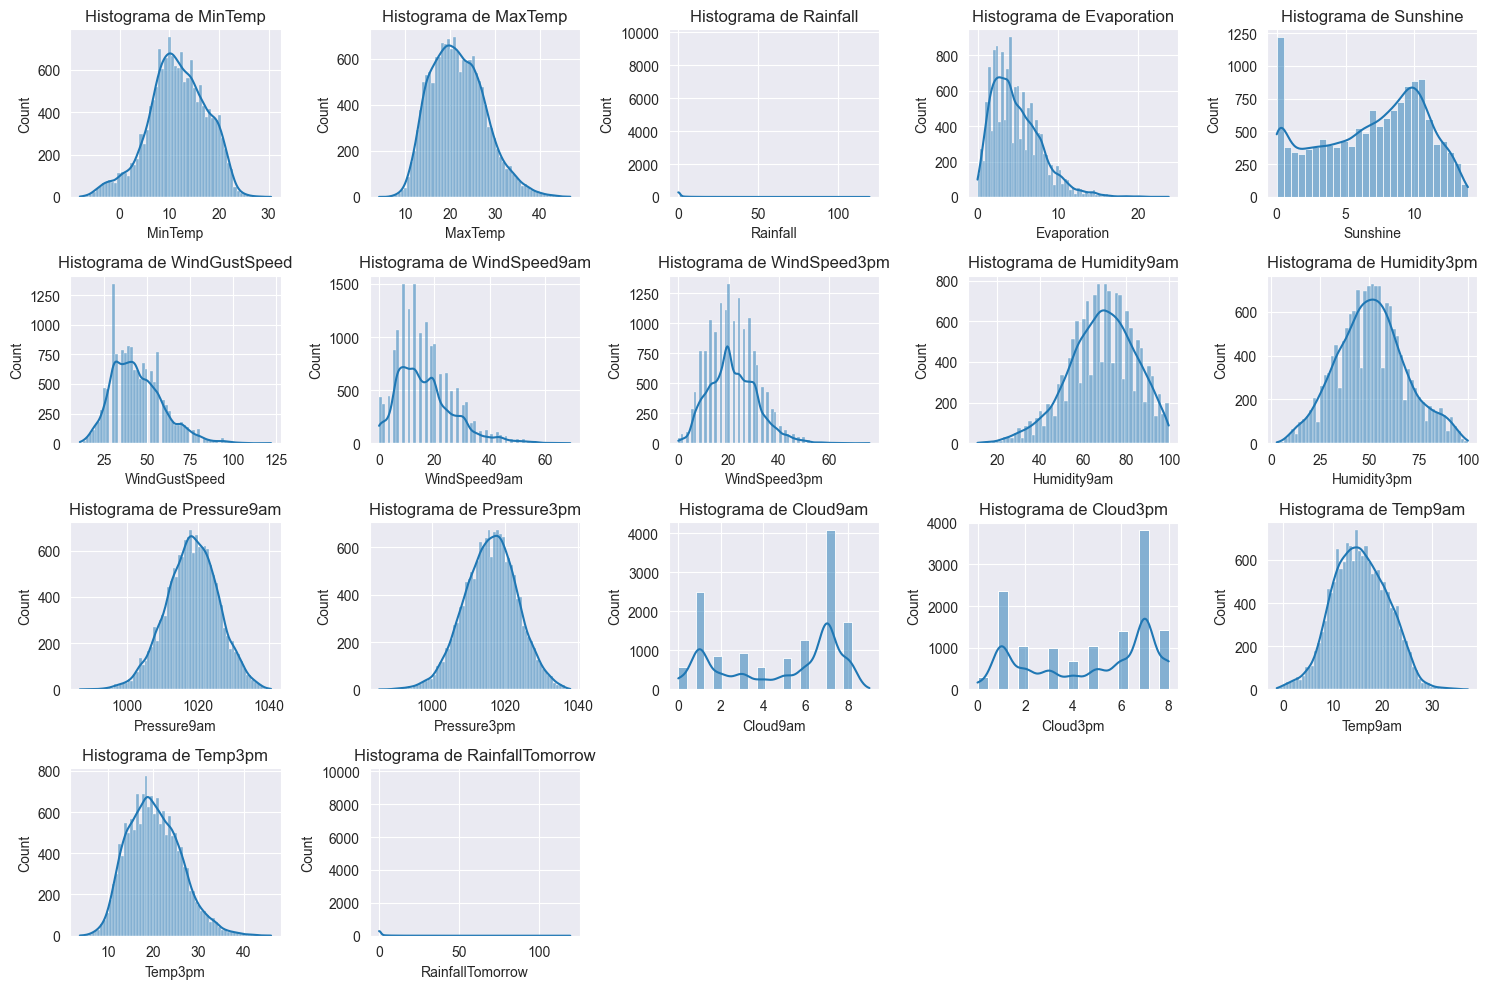

In [11]:
# Seleccionar columnas numéricas
numeric_columns = df.select_dtypes(include=[np.float64]).columns

# Realizamos histogramas de las columnas numéricas para observar su dispersión
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()


Podemos observar los distintos tipos de distribución, entre ellas hay varias columnas que presentan una distribución normal

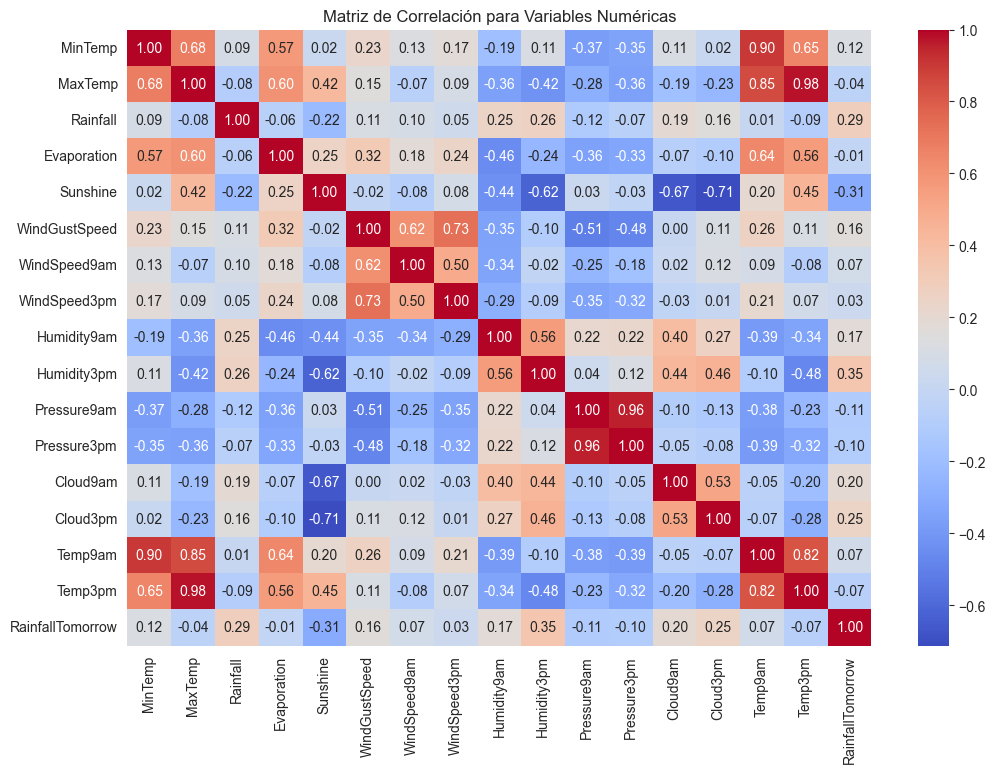

In [12]:
# Matriz de correlación para variables numéricas
correlation_matrix_numeric = df[numeric_columns].corr()

# Plotear la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()


Podemos observar que las variables con mayor correlación con RainfallTomorrow son:

*   Humidity3pm 0.35
*   Sunshine -0.31
*   Rainfall 0.29
*   Cloud3pm 0.25

## Dividimos en 2 el dataset entrenadmiento y pruebas

In [13]:
train, test = train_test_split(df, test_size=0.2, random_state=10)

66619    MelbourneAirport
67719           Melbourne
30643              Sydney
67421           Melbourne
66521    MelbourneAirport
               ...       
66018    MelbourneAirport
31511              Sydney
67200           Melbourne
46515            Canberra
31456              Sydney
Name: Location, Length: 12788, dtype: object


### Realizamos la limpieza en la clase clean y volvemos a visualizar los datos

In [14]:
data = Clean(train)
data_clean = data.process()
data_clean.head()

Archivo guardado exitosamente en 'data/weatherAUS_clean.csv'


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
66619,8.1,29.8,0.0,6.0,12.1,3.0,9.0,24.0,45.0,9.0,1016.6,1012.8,4.0,7.0,17.8,28.4,0,0,0.0
67719,16.2,39.0,0.0,6.2,11.3,4.0,7.0,26.0,62.0,15.0,1010.2,1005.9,3.0,4.0,21.1,38.1,0,0,0.0
67421,16.1,23.2,0.0,12.4,6.3,3.0,17.0,31.0,66.0,43.0,1013.2,1012.2,7.0,2.0,17.6,22.1,0,1,1.6
66521,3.6,15.4,0.0,2.2,1.8,1.0,31.0,31.0,75.0,56.0,1020.0,1014.8,8.0,7.0,10.7,13.5,0,1,5.2
66960,13.8,20.1,0.0,10.0,0.7,3.0,6.0,20.0,78.0,67.0,1016.8,1016.8,8.0,7.0,16.3,18.3,0,0,0.0


In [47]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12595 entries, 66619 to 31456
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           12595 non-null  float64
 1   MaxTemp           12595 non-null  float64
 2   Rainfall          12595 non-null  float64
 3   Evaporation       12595 non-null  float64
 4   Sunshine          12595 non-null  float64
 5   WindGustDir       12595 non-null  float64
 6   WindSpeed9am      12595 non-null  float64
 7   WindSpeed3pm      12595 non-null  float64
 8   Humidity9am       12595 non-null  float64
 9   Humidity3pm       12595 non-null  float64
 10  Pressure9am       12595 non-null  float64
 11  Pressure3pm       12595 non-null  float64
 12  Cloud9am          12595 non-null  float64
 13  Cloud3pm          12595 non-null  float64
 14  Temp9am           12595 non-null  float64
 15  Temp3pm           12595 non-null  float64
 16  RainToday         12595 non-null  int64  

In [48]:
data_clean.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000,12595.000000
mean,11.635593,21.696141,2.224073,4.820961,6.918388,2.547042,16.664549,21.877412,68.878206,51.421755,1018.299444,1016.055593,4.747995,4.770623,15.568726,20.214712,0.222946,0.233982,2.249274
std,5.783264,6.019806,7.341772,3.046149,3.811453,1.159945,10.365443,9.532792,15.617828,17.718306,7.445851,7.316185,2.725230,2.583593,5.536191,5.830818,0.416239,0.423378,7.485012
min,-8.000000,4.100000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000,0.000000,0.000000
25%,8.000000,17.100000,0.000000,2.400000,3.900000,1.000000,9.000000,15.000000,59.000000,39.000000,1013.400000,1011.200000,2.000000,2.000000,11.600000,15.900000,0.000000,0.000000,0.000000
50%,11.600000,21.200000,0.000000,4.200000,7.700000,3.000000,15.000000,20.000000,70.000000,51.000000,1018.500000,1016.300000,6.000000,6.000000,15.400000,19.800000,0.000000,0.000000,0.000000
75%,15.800000,25.700000,0.600000,6.600000,10.000000,4.000000,22.000000,28.000000,80.000000,62.000000,1023.300000,1021.100000,7.000000,7.000000,19.500000,24.100000,0.000000,0.000000,0.600000
max,27.600000,46.800000,119.400000,23.800000,13.900000,4.000000,69.000000,76.000000,100.000000,99.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,1.000000,1.000000,119.400000


In [49]:
print(data_clean.columns)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')


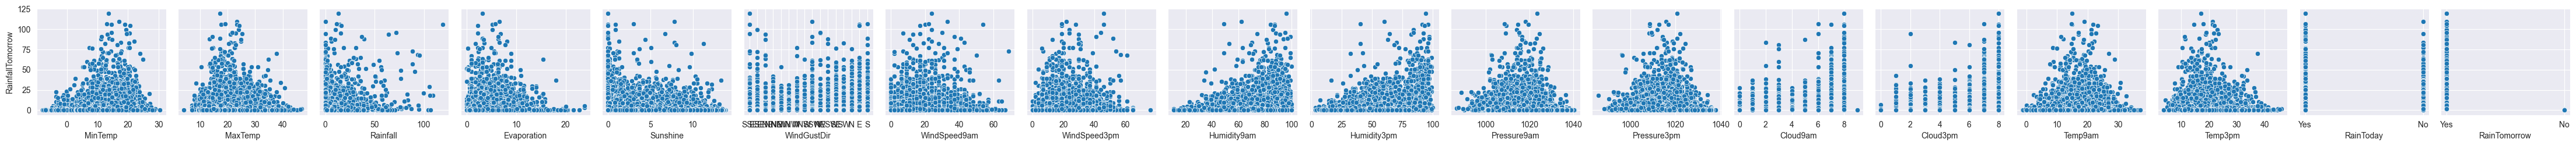

In [18]:
#Observamos la distribución para ver si hay linealidad
columnas = [col for col in data_clean.columns if ((col != 'RainfallTomorrow') & (col != 'Location') & (col != 'Date'))]

sns.pairplot(df, x_vars=columnas, y_vars='RainfallTomorrow')
plt.show()

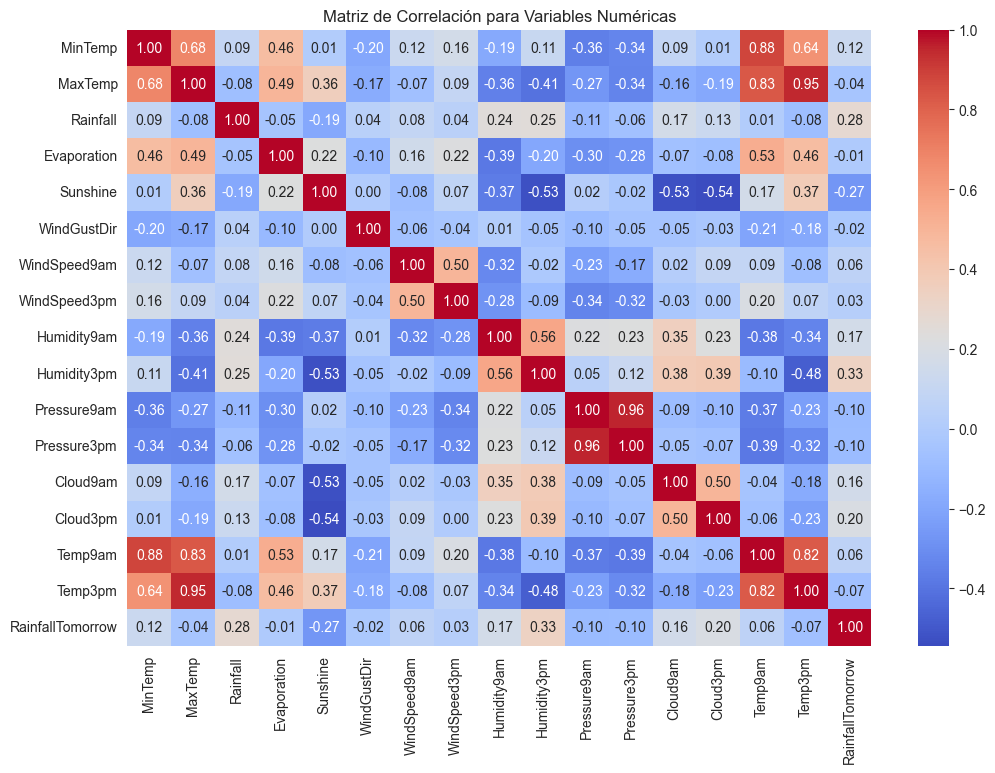

In [50]:
# Seleccionar columnas numéricas
numeric_columns = data_clean.select_dtypes(include=[np.float64, np.int32]).columns

# Matriz de correlación para variables numéricas
correlation_matrix_numeric = data_clean[numeric_columns].corr()

# Plotear la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()

### En esta parte implementamos en simultaneo las siguientes consignas:

* Implementar la solución del problema de regresión con regresión lineal múltiple.

* Optimizar la selección de hiperparámetros.

* Implementar explicabilidad del modelo. SHAP


In [51]:
regresion_clasic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regresion_clasic.classic()
metricas = regresion_clasic.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal clasic:")
print(metricas)

Métricas del modelo Regresion lineal clasic:
{'MSE': 44.538969649695, 'R2': 0.21352022356812184, 'RMSE': 6.673752291604401, 'MAE': 3.0938696346773025, 'MAPE': inf}


In [52]:
#aplicamos validación cruzada
regresion_clasic.cross_validate(x_test, y_test, modelo, cv=5)
print(f"El modelo")
print(x_test)

Mean Squared Error (CV): 45.043238488132474
R^2 Score (CV): 0.20461572383597337
Mean Absolute Error (CV): 3.2638656870774514


(45.043238488132474, 0.20461572383597337, 3.2638656870774514)

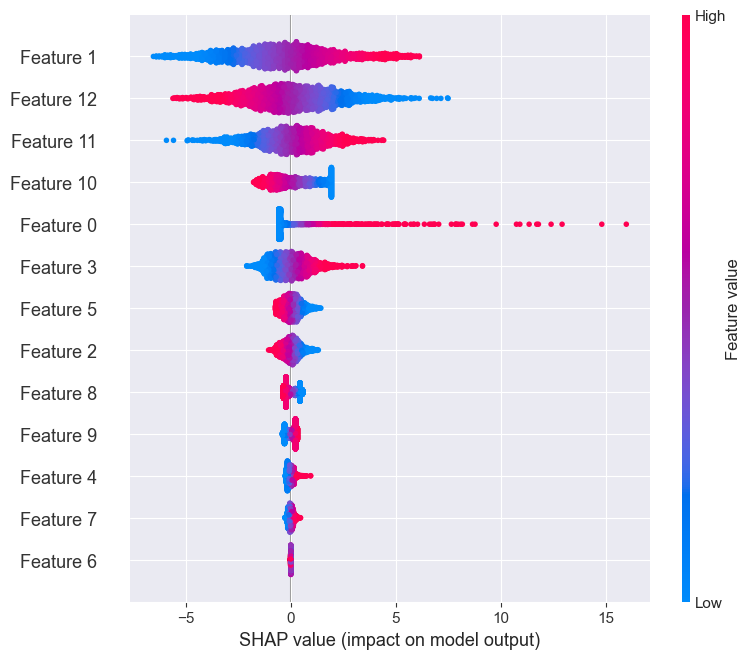

In [22]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [23]:
print('métodos de gradiente descendiente')
regresion_gradient_desecent = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regresion_gradient_desecent.gradient_descent()
metricas = regresion_gradient_desecent.metrics(y_test, y_pred)
print(f"Métricas del Modelo:")
print(metricas)

métodos de gradiente descendiente
Métricas del Modelo:
{'MSE': 47.16532846673996, 'R2': 0.16714335155007853, 'RMSE': 6.867701832981682, 'MAE': 3.2360123013715336, 'MAPE': inf}


In [24]:
#aplicamos validación cruzada
regresion_gradient_desecent.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 50.05162845094559
R^2 Score (CV): 0.11617637624401822
Mean Absolute Error (CV): 3.5021210812255332


(50.05162845094559, 0.11617637624401822, 3.5021210812255332)

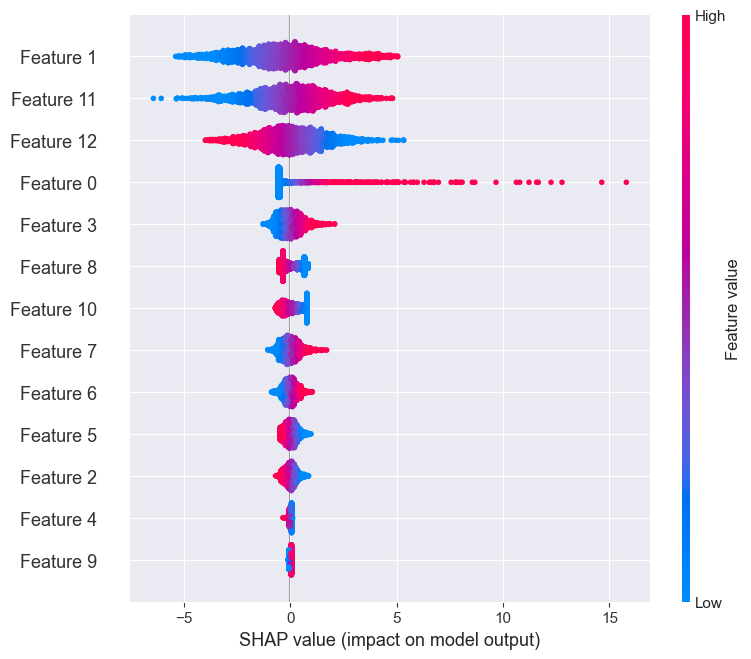

In [25]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [26]:
param_grid = {
    'fit_intercept': [True, False],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 500, 1000]  
}

regresion_gradient_descent = RegressionLineal(data_clean)
x_test, y_test, y_pred, best_model = regresion_gradient_descent.gradient_descent_optimize_hyperparameters(param_grid)
metricas = regresion_gradient_descent.metrics(y_test, y_pred)
print(f"Métricas del mejor modelo:")
print(metricas)
print("Mejores hiperparámetros:", best_model.get_params())

Métricas del mejor modelo:
{'MSE': 47.373699883217036, 'R2': 0.16346387925122163, 'RMSE': 6.882855503584035, 'MAE': 2.975680496294088, 'MAPE': inf}
Mejores hiperparámetros: {'alpha': 1.0, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'adaptive', 'loss': 'squared_error', 'max_iter': 200, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


## Regresión linean de Lasso

In [27]:
# regresion de Lasso
regresion_lasso = RegressionLineal(data_clean)
x_test, y_test, y_pred, lasso_model = regresion_lasso.lasso_regression()
metricas = regresion_lasso.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Lasso:")
print(metricas)

Métricas del modelo Regresion lineal Lasso:
{'MSE': 49.075910368581255, 'R2': 0.13340583946047813, 'RMSE': 7.005420070815258, 'MAE': 3.06494815684165, 'MAPE': inf}


In [28]:
#aplicamos validación cruzada
regresion_lasso.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 48.73907844658614
R^2 Score (CV): 0.13935369808382303
Mean Absolute Error (CV): 3.442493646159941


(48.73907844658614, 0.13935369808382303, 3.442493646159941)

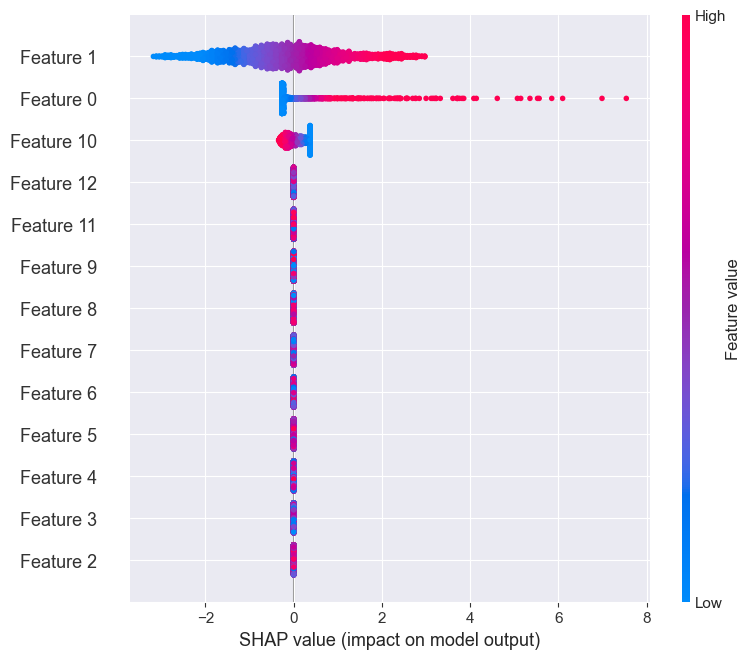

In [29]:
try:
    shap_analyzer = SHAPAnalyzer(lasso_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [30]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Lasso', param_grid_lasso)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Lasso:")
print(metricas_lasso)
print("Mejores hiperparámetros para Lasso:", best_lasso_model.get_params())


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Métricas del mejor modelo Lasso:
{'MSE': 44.5454149556435, 'R2': 0.21340641081445277, 'RMSE': 6.67423515885105, 'MAE': 3.0927357928190635, 'MAPE': inf}
Mejores hiperparámetros para Lasso: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Regresión lineal de Ridge

In [31]:
# regresion de Ridge

regresion_ridge = RegressionLineal(data_clean)
x_test, y_test, y_pred, ridge_model = regresion_ridge.ridge_regression()
metricas = regresion_lasso.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Ridge:")
print(metricas)


Métricas del modelo Regresion lineal Ridge:
{'MSE': 44.53932402292849, 'R2': 0.2135139659608254, 'RMSE': 6.673778841325841, 'MAE': 3.0937337783138616, 'MAPE': inf}


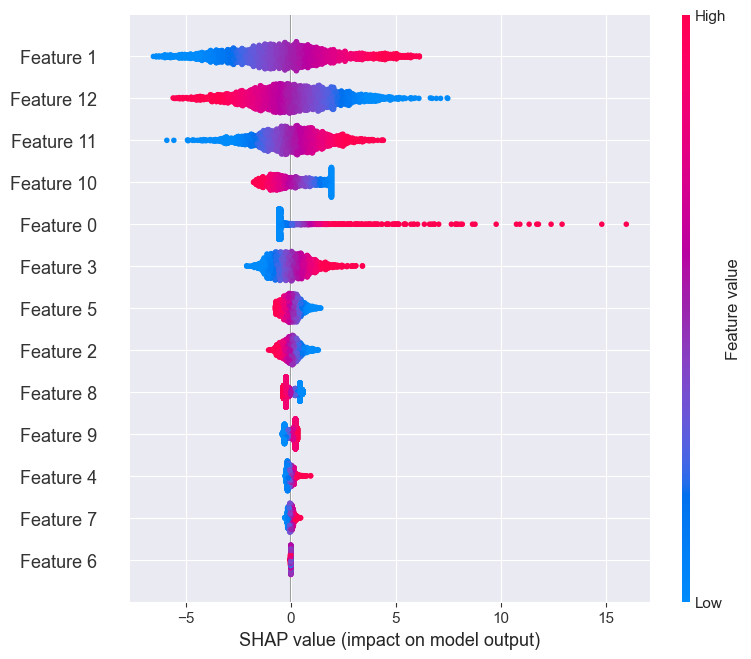

In [32]:
try:
    shap_analyzer = SHAPAnalyzer(ridge_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [33]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Ridge = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Ridge', param_grid_Ridge)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Ridge:")
print(metricas_lasso)
print("Mejores hiperparámetros para Ridge:", best_lasso_model.get_params())

Métricas del mejor modelo Ridge:
{'MSE': 44.53972949274949, 'R2': 0.2135068060777685, 'RMSE': 6.673809219085416, 'MAE': 3.093684907199259, 'MAPE': inf}
Mejores hiperparámetros para Ridge: {'alpha': 100.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


## Regresión lineal de Elasticnet

In [34]:
# regresion de Elasticnet

regresion_elasticnet = RegressionLineal(data_clean)
x_test, y_test, y_pred, elasticnet_model = regresion_elasticnet.elasticnet_regression()
metricas = regresion_elasticnet.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Elasticnet:")
print(metricas)

Métricas del modelo Regresion lineal Elasticnet:
{'MSE': 48.128570854188595, 'R2': 0.15013418713768412, 'RMSE': 6.937475827286795, 'MAE': 2.979272970301916, 'MAPE': inf}


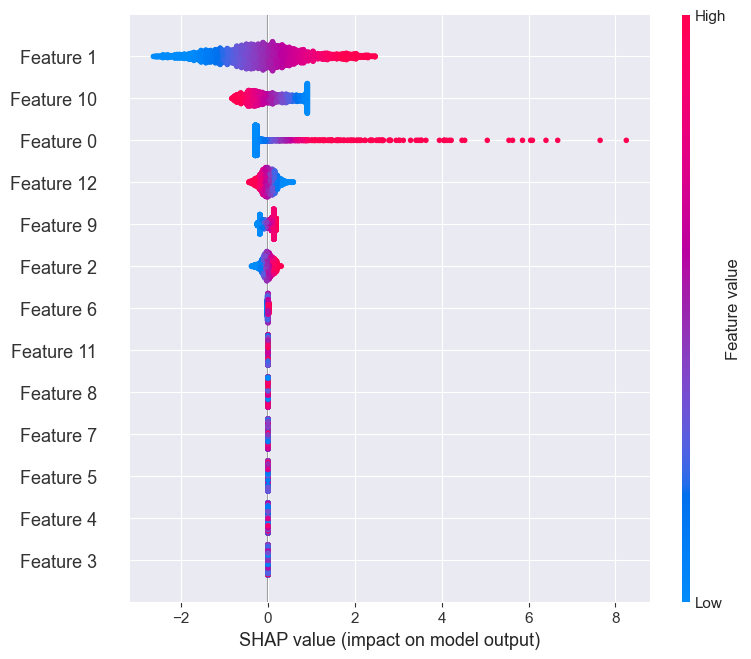

In [35]:
try:
    shap_analyzer = SHAPAnalyzer(elasticnet_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [36]:
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Puedes ajustar estos valores según sea necesario
}
# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_elasticnet, best_lasso_model = regresion_lineal.optimize_hyperparameters('ElasticNet', param_grid_Elasticnet)

# Calcular métricas
metricas_elasticnet = regresion_lineal.metrics(y_test, y_pred_elasticnet)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Elasticnet:")
print(metricas_elasticnet)
print("Mejores hiperparámetros para Elasticnet:", best_lasso_model.get_params())

Métricas del mejor modelo Elasticnet:
{'MSE': 44.5803086374623, 'R2': 0.21279024983696315, 'RMSE': 6.6768487055992445, 'MAE': 3.0881985294234506, 'MAPE': inf}
Mejores hiperparámetros para Elasticnet: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Regresión Logística

Accuracy: 0.98
Precision: 0.97
Recall: 0.93
F1 Score: 0.95
ROC-AUC: 0.96
Matiz de confusión:
          pred: No  Pred: Si
Real: No      1900        16
Real: si        40       563


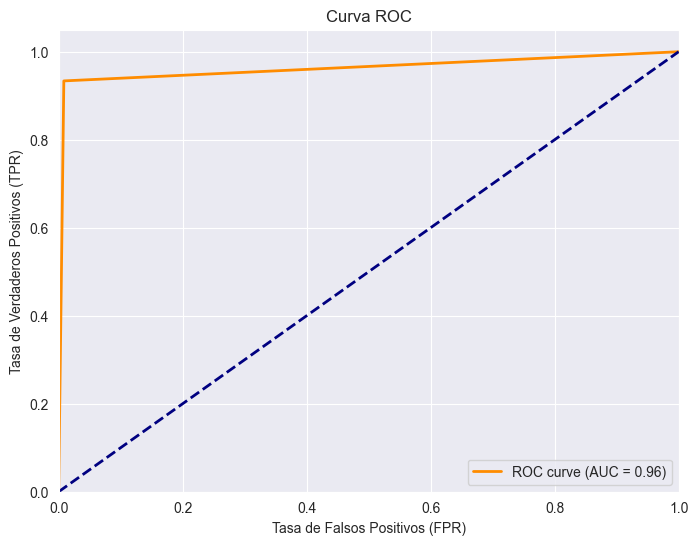

In [37]:
#regresion logistica
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic()
regression_logistic.logic_metrics(y_test, y_pred)

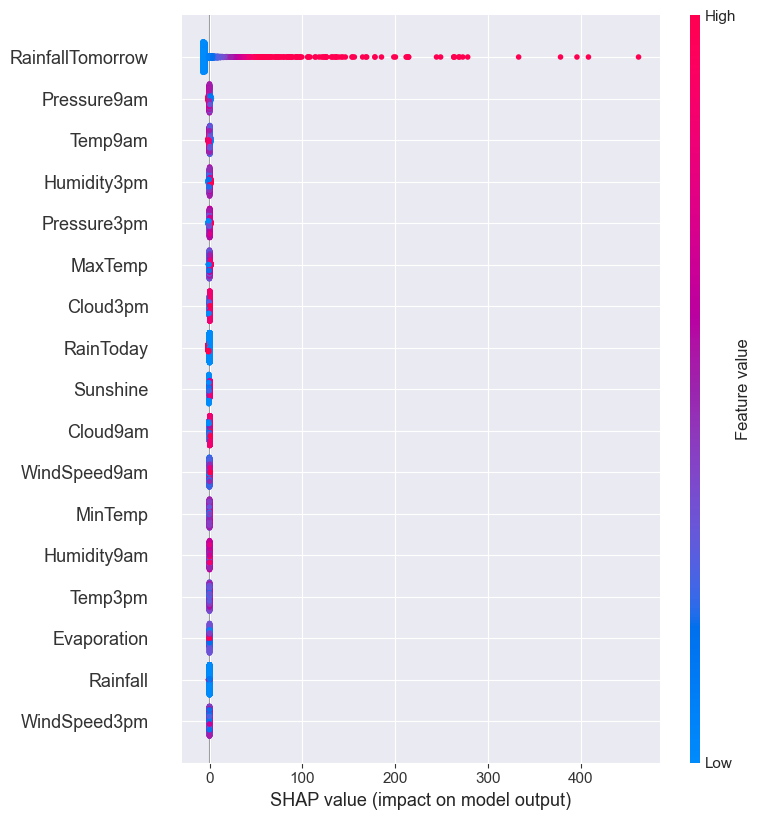

In [38]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [39]:
regresion_lineal = RegressionLineal(data_clean)
#buscando los hipperparametros
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
x_test_logistic, y_test_logistic, y_pred_logistic, best_logistic_model = regresion_lineal.optimize_hyperparameters_logistic(param_grid_logistic)

# Calcular métricas
metricas_logistic = regresion_lineal.metrics(y_test_logistic, y_pred_logistic)

# Imprimir métricas y mejores hiperparámetros para la regresión logística
print(f"Métricas del mejor modelo de regresión logística:")
print(metricas_logistic)
print("Mejores hiperparámetros para la regresión logística:", best_logistic_model.get_params())


Métricas del mejor modelo de regresión logística:
{'MSE': 0.01945216355696705, 'R2': 0.8919279794206904, 'RMSE': 0.13947101332164705, 'MAE': 0.01945216355696705, 'MAPE': inf}
Mejores hiperparámetros para la regresión logística: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Observamos que tanto el modelo como la validación cruzada tienden a sobreajustar las predicciones hacia la clase negativa. Esto se debe a que la clase negativa es la más predominante. Para abordar este desbalance, procedemos a equilibrar las clases.

Accuracy: 0.97
Precision: 0.94
Recall: 0.95
F1 Score: 0.94
ROC-AUC: 0.96
Matiz de confusión:
          pred: No  Pred: Si
Real: No      1887        39
Real: si        32       561


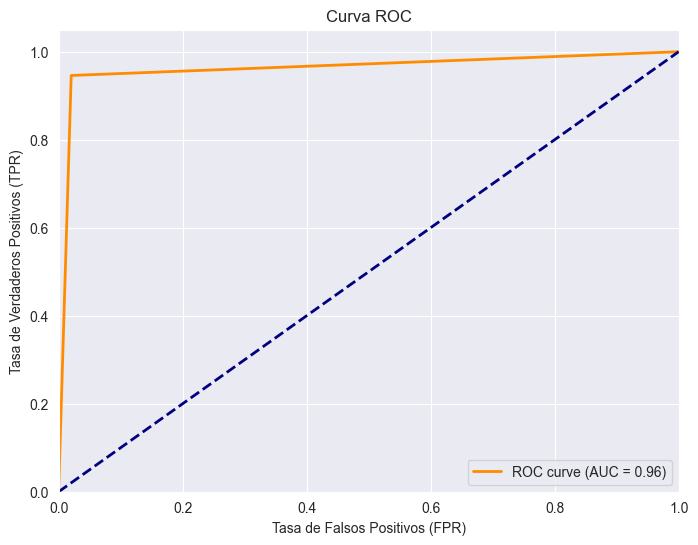

In [40]:
#regresion logistica balanceada
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic_balanced()
regression_logistic.logic_metrics(y_test, y_pred)

### Optamos por mantener el modelo balanceado, ya que aunque observamos una disminución en las métricas de predicción negativa, consideramos prioritario mejorar las métricas de predicción positiva. En este contexto, valoramos una mayor precisión en la anticipación de días lluviosos.

## Implementar un modelo base para clasificación y uno para regresión

In [41]:
#modelo base
regresion_model = RegresionModelBase(data_clean)
x_test, y_test, y_pred, modelo = regresion_model.regresion()


# También puedes acceder a los atributos del mejor modelo obtenido
print("Mejores hiperparámetros encontrados mediante Grid Search:")
print(modelo.get_params())

Error Cuadrático Medio en el conjunto de prueba: 28.732891713004207
Error Absoluto Medio en el conjunto de prueba: 2.211838463114317
Raíz del Error Cuadrático Medio en el conjunto de prueba: 5.360307053985267
Coeficiente de Determinación (R^2) en el conjunto de prueba: 0.35536131812428506
Mejores hiperparámetros encontrados mediante Grid Search:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


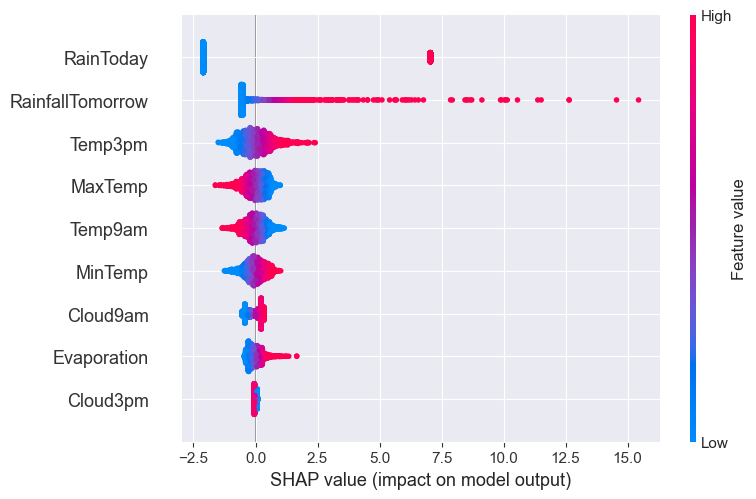

In [42]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [43]:
#clasificador Base
clasification_model = ClasificationModelBase(data_clean)
# Entrenar el modelo y obtener los resultados
x_test, y_test, predictions, best_model = clasification_model.clasificacion()
print("Mejores hiperparámetros encontrados mediante Grid Search:")
print(best_model.get_params())

Precisión en el conjunto de prueba: 0.68
Recall en el conjunto de prueba: 0.30
F1-score en el conjunto de prueba: 0.42
Exactitud en el conjunto de prueba: 0.80
Mejores hiperparámetros encontrados mediante Grid Search:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


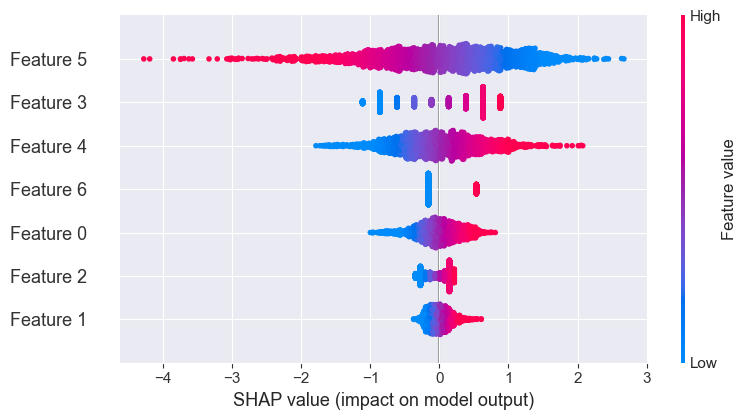

In [44]:
try:
    shap_analyzer = SHAPAnalyzer(best_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

## Implementar las soluciones con una red neuronal

In [45]:
print('=============================clasificacion con redes neuronales================================================')
classification_nn_model = ClassificationNeuralNetwork(data_clean)
trained_model = classification_nn_model.classification()


[I 2024-02-24 17:12:21,452] A new study created in memory with name: no-name-557711bc-782e-437a-a31d-bc51868d851c


=============================clasificacion con redes neuronales================================================
79/79 [==============================] - 0s 787us/step


[I 2024-02-24 17:12:26,670] Trial 0 finished with value: 0.23541087733227473 and parameters: {'num_layers': 3, 'n_units_l0': 10, 'n_units_l1': 16, 'n_units_l2': 9, 'learning_rate': 0.06629927326335028}. Best is trial 0 with value: 0.23541087733227473.


79/79 [==============================] - 0s 852us/step


[I 2024-02-24 17:12:31,793] Trial 1 finished with value: 0.49821357681619693 and parameters: {'num_layers': 3, 'n_units_l0': 11, 'n_units_l1': 16, 'n_units_l2': 15, 'learning_rate': 1.3892047288566875e-05}. Best is trial 0 with value: 0.23541087733227473.


79/79 [==============================] - 0s 692us/step


[I 2024-02-24 17:12:35,200] Trial 2 finished with value: 0.1258435887256848 and parameters: {'num_layers': 1, 'n_units_l0': 4, 'learning_rate': 0.004944504935789337}. Best is trial 2 with value: 0.1258435887256848.


79/79 [==============================] - 0s 799us/step


[I 2024-02-24 17:12:39,325] Trial 3 finished with value: 0.18181818181818177 and parameters: {'num_layers': 2, 'n_units_l0': 9, 'n_units_l1': 3, 'learning_rate': 0.00046344839607421654}. Best is trial 2 with value: 0.1258435887256848.


79/79 [==============================] - 0s 701us/step


[I 2024-02-24 17:12:42,858] Trial 4 finished with value: 0.1750694720127035 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.004220778778298175}. Best is trial 2 with value: 0.1258435887256848.


79/79 [==============================] - 0s 769us/step


[I 2024-02-24 17:12:46,333] Trial 5 finished with value: 0.0003969829297340022 and parameters: {'num_layers': 1, 'n_units_l0': 8, 'learning_rate': 0.008181105278860559}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 785us/step


[I 2024-02-24 17:12:51,395] Trial 6 finished with value: 0.21794362842397774 and parameters: {'num_layers': 3, 'n_units_l0': 3, 'n_units_l1': 4, 'n_units_l2': 12, 'learning_rate': 0.0004990221034140112}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 728us/step


[I 2024-02-24 17:12:55,895] Trial 7 finished with value: 0.2246923382294561 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 0.00010747582329689782}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 809us/step


[I 2024-02-24 17:13:00,875] Trial 8 finished with value: 0.23541087733227473 and parameters: {'num_layers': 3, 'n_units_l0': 2, 'n_units_l1': 10, 'n_units_l2': 9, 'learning_rate': 0.0002811201503397588}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 793us/step


[I 2024-02-24 17:13:05,802] Trial 9 finished with value: 0.4771734815402938 and parameters: {'num_layers': 3, 'n_units_l0': 12, 'n_units_l1': 6, 'n_units_l2': 8, 'learning_rate': 1.947083367529401e-05}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 790us/step


[I 2024-02-24 17:13:10,159] Trial 10 finished with value: 0.23541087733227473 and parameters: {'num_layers': 2, 'n_units_l0': 16, 'n_units_l1': 11, 'learning_rate': 0.07298292958941754}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 696us/step


[I 2024-02-24 17:13:13,585] Trial 11 finished with value: 0.16077808654227865 and parameters: {'num_layers': 1, 'n_units_l0': 5, 'learning_rate': 0.004419459302108255}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 691us/step


[I 2024-02-24 17:13:17,043] Trial 12 finished with value: 0.01865819769749899 and parameters: {'num_layers': 1, 'n_units_l0': 6, 'learning_rate': 0.0064367371356094044}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 871us/step


[I 2024-02-24 17:13:21,164] Trial 13 finished with value: 0.23541087733227473 and parameters: {'num_layers': 2, 'n_units_l0': 6, 'n_units_l1': 1, 'learning_rate': 0.018109954921780833}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 689us/step


[I 2024-02-24 17:13:24,615] Trial 14 finished with value: 0.23541087733227473 and parameters: {'num_layers': 1, 'n_units_l0': 7, 'learning_rate': 0.012318619076627112}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 811us/step


[I 2024-02-24 17:13:28,073] Trial 15 finished with value: 0.05676855895196509 and parameters: {'num_layers': 1, 'n_units_l0': 7, 'learning_rate': 0.0022662261126285637}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 769us/step


[I 2024-02-24 17:13:32,443] Trial 16 finished with value: 0.23144104803493448 and parameters: {'num_layers': 2, 'n_units_l0': 14, 'n_units_l1': 12, 'learning_rate': 0.020028127541556657}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 717us/step


[I 2024-02-24 17:13:36,152] Trial 17 finished with value: 0.23541087733227473 and parameters: {'num_layers': 1, 'n_units_l0': 1, 'learning_rate': 0.001296302272658182}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 1ms/step


[I 2024-02-24 17:13:42,707] Trial 18 finished with value: 0.2242953552997221 and parameters: {'num_layers': 2, 'n_units_l0': 8, 'n_units_l1': 8, 'learning_rate': 0.011741084212418925}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 1ms/step


[I 2024-02-24 17:13:47,535] Trial 19 finished with value: 0.23541087733227473 and parameters: {'num_layers': 1, 'n_units_l0': 5, 'learning_rate': 0.030120575192960533}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 751us/step


[I 2024-02-24 17:13:52,916] Trial 20 finished with value: 0.20921000396982925 and parameters: {'num_layers': 2, 'n_units_l0': 13, 'n_units_l1': 13, 'learning_rate': 8.434786780969326e-05}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 717us/step


[I 2024-02-24 17:13:56,555] Trial 21 finished with value: 0.05121079793568872 and parameters: {'num_layers': 1, 'n_units_l0': 7, 'learning_rate': 0.001756753835991467}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 728us/step


[I 2024-02-24 17:14:00,242] Trial 22 finished with value: 0.17705438666137352 and parameters: {'num_layers': 1, 'n_units_l0': 8, 'learning_rate': 0.0018667187800393613}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 715us/step


[I 2024-02-24 17:14:03,892] Trial 23 finished with value: 0.06867804684398571 and parameters: {'num_layers': 1, 'n_units_l0': 7, 'learning_rate': 0.006954795642794019}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 712us/step


[I 2024-02-24 17:14:07,598] Trial 24 finished with value: 0.08257244938467645 and parameters: {'num_layers': 1, 'n_units_l0': 5, 'learning_rate': 0.0006733698833401711}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 686us/step


[I 2024-02-24 17:14:11,288] Trial 25 finished with value: 0.11472806669313218 and parameters: {'num_layers': 1, 'n_units_l0': 9, 'learning_rate': 0.002868837036416143}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 854us/step


[I 2024-02-24 17:14:15,929] Trial 26 finished with value: 0.23541087733227473 and parameters: {'num_layers': 2, 'n_units_l0': 6, 'n_units_l1': 7, 'learning_rate': 0.04298004206346897}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 744us/step


[I 2024-02-24 17:14:19,442] Trial 27 finished with value: 0.23541087733227473 and parameters: {'num_layers': 1, 'n_units_l0': 3, 'learning_rate': 0.00877051079547105}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 769us/step


[I 2024-02-24 17:14:22,943] Trial 28 finished with value: 0.027391822151647482 and parameters: {'num_layers': 1, 'n_units_l0': 6, 'learning_rate': 0.001245845842311919}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 763us/step


[I 2024-02-24 17:14:27,240] Trial 29 finished with value: 0.23541087733227473 and parameters: {'num_layers': 2, 'n_units_l0': 4, 'n_units_l1': 14, 'learning_rate': 0.0001815089049950583}. Best is trial 5 with value: 0.0003969829297340022.


79/79 [==============================] - 0s 713us/step


[I 2024-02-24 17:14:30,781] Trial 30 finished with value: 0.0 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.0009745377585976002}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 759us/step


[I 2024-02-24 17:14:34,747] Trial 31 finished with value: 0.0003969829297340022 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.0006832237996308993}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 888us/step


[I 2024-02-24 17:14:38,315] Trial 32 finished with value: 0.0007939658594680044 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.0008715934957782742}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 728us/step


[I 2024-02-24 17:14:41,886] Trial 33 finished with value: 0.02858277094084949 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.0008464967254035919}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 750us/step


[I 2024-02-24 17:14:45,478] Trial 34 finished with value: 0.1175069472012703 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 0.00027374104731354065}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 743us/step


[I 2024-02-24 17:14:49,042] Trial 35 finished with value: 0.1448987693529178 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.00031858461240590264}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 712us/step


[I 2024-02-24 17:14:52,624] Trial 36 finished with value: 0.19094878920206426 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 6.557826052029537e-05}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 715us/step


[I 2024-02-24 17:14:56,233] Trial 37 finished with value: 0.01826121476776499 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 0.0006144301346055737}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 844us/step


[I 2024-02-24 17:15:00,482] Trial 38 finished with value: 0.046447002778880475 and parameters: {'num_layers': 2, 'n_units_l0': 9, 'n_units_l1': 5, 'learning_rate': 0.002975297428025168}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 708us/step


[I 2024-02-24 17:15:04,076] Trial 39 finished with value: 0.1472806669313219 and parameters: {'num_layers': 1, 'n_units_l0': 14, 'learning_rate': 0.00013710211162954272}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 713us/step


[I 2024-02-24 17:15:07,679] Trial 40 finished with value: 0.22548630408892423 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 4.44512521081737e-05}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 691us/step


[I 2024-02-24 17:15:11,227] Trial 41 finished with value: 0.024612941643509356 and parameters: {'num_layers': 1, 'n_units_l0': 11, 'learning_rate': 0.0005330595845591322}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 719us/step


[I 2024-02-24 17:15:14,757] Trial 42 finished with value: 0.00674870980547837 and parameters: {'num_layers': 1, 'n_units_l0': 9, 'learning_rate': 0.0009730005248167101}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 694us/step


[I 2024-02-24 17:15:18,299] Trial 43 finished with value: 0.0011909487892021176 and parameters: {'num_layers': 1, 'n_units_l0': 9, 'learning_rate': 0.001170641874965431}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 707us/step


[I 2024-02-24 17:15:21,787] Trial 44 finished with value: 0.13934100833664154 and parameters: {'num_layers': 1, 'n_units_l0': 8, 'learning_rate': 0.0003256519807191984}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 780us/step


[I 2024-02-24 17:15:25,343] Trial 45 finished with value: 0.00674870980547837 and parameters: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.0035654303835249966}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 840us/step


[I 2024-02-24 17:15:30,714] Trial 46 finished with value: 0.23541087733227473 and parameters: {'num_layers': 3, 'n_units_l0': 10, 'n_units_l1': 1, 'n_units_l2': 2, 'learning_rate': 0.0015881221841928992}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 699us/step


[I 2024-02-24 17:15:34,752] Trial 47 finished with value: 0.1639539499801509 and parameters: {'num_layers': 1, 'n_units_l0': 12, 'learning_rate': 0.00021328453146826255}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 801us/step


[I 2024-02-24 17:15:39,119] Trial 48 finished with value: 0.17070265978562926 and parameters: {'num_layers': 2, 'n_units_l0': 9, 'n_units_l1': 9, 'learning_rate': 0.0003762848640324279}. Best is trial 30 with value: 0.0.


79/79 [==============================] - 0s 798us/step


[I 2024-02-24 17:15:42,586] Trial 49 finished with value: 0.0027788805081381263 and parameters: {'num_layers': 1, 'n_units_l0': 8, 'learning_rate': 0.0007895878260642444}. Best is trial 30 with value: 0.0.


Mejor valor encontrado: 0.0
Mejores hiperparámetros: {'num_layers': 1, 'n_units_l0': 10, 'learning_rate': 0.0009745377585976002}
79/79 [==============================] - 0s 765us/step
Precisión en el conjunto de prueba: 1.0
Recall en el conjunto de prueba: 0.9881956155143339
F1-score en el conjunto de prueba: 0.9940627650551315
Exactitud en el conjunto de prueba: 0.9972211194918619


In [46]:
regression_nn_model = RegressionNeuralNetwork(data_clean)
regression_nn_model.regression()

[I 2024-02-24 17:15:46,125] A new study created in memory with name: no-name-1e61e33e-ed06-4de7-9163-70ef4dcded81
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 582us/step


[I 2024-02-24 17:15:48,994] Trial 0 finished with value: 49.2221581244628 and parameters: {'learning_rate': 3.059504962612614e-05}. Best is trial 0 with value: 49.2221581244628.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 603us/step


[I 2024-02-24 17:15:51,858] Trial 1 finished with value: 36.83698044460528 and parameters: {'learning_rate': 0.00036610435290765976}. Best is trial 1 with value: 36.83698044460528.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 583us/step


[I 2024-02-24 17:15:54,750] Trial 2 finished with value: 0.14812918014278875 and parameters: {'learning_rate': 0.006894020021831079}. Best is trial 2 with value: 0.14812918014278875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 764us/step


[I 2024-02-24 17:15:57,648] Trial 3 finished with value: 54.14833227032716 and parameters: {'learning_rate': 0.00010053974349292874}. Best is trial 2 with value: 0.14812918014278875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 604us/step


[I 2024-02-24 17:16:00,516] Trial 4 finished with value: 31.000300509754275 and parameters: {'learning_rate': 0.0005229976004535562}. Best is trial 2 with value: 0.14812918014278875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 586us/step


[I 2024-02-24 17:16:03,408] Trial 5 finished with value: 7.878256516633275 and parameters: {'learning_rate': 0.0024054856525825403}. Best is trial 2 with value: 0.14812918014278875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 575us/step


[I 2024-02-24 17:16:06,287] Trial 6 finished with value: 38.82872744850416 and parameters: {'learning_rate': 0.0001458586355929578}. Best is trial 2 with value: 0.14812918014278875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 710us/step


[I 2024-02-24 17:16:09,158] Trial 7 finished with value: 27.95251794177049 and parameters: {'learning_rate': 0.0011434346662006424}. Best is trial 2 with value: 0.14812918014278875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 651us/step


[I 2024-02-24 17:16:12,022] Trial 8 finished with value: 45.90276003725027 and parameters: {'learning_rate': 8.180089471068385e-05}. Best is trial 2 with value: 0.14812918014278875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 583us/step


[I 2024-02-24 17:16:14,904] Trial 9 finished with value: 31.64588632594754 and parameters: {'learning_rate': 0.0004481538598328971}. Best is trial 2 with value: 0.14812918014278875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 628us/step


[I 2024-02-24 17:16:17,810] Trial 10 finished with value: 1.7209190484639221e-12 and parameters: {'learning_rate': 0.03649043138503337}. Best is trial 10 with value: 1.7209190484639221e-12.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 717us/step


[I 2024-02-24 17:16:20,688] Trial 11 finished with value: 2.8531174194916835e-12 and parameters: {'learning_rate': 0.05067656892542367}. Best is trial 10 with value: 1.7209190484639221e-12.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 582us/step


[I 2024-02-24 17:16:23,571] Trial 12 finished with value: 1.7331046166282621e-12 and parameters: {'learning_rate': 0.06256758936981398}. Best is trial 10 with value: 1.7209190484639221e-12.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 655us/step


[I 2024-02-24 17:16:26,469] Trial 13 finished with value: 2.2932201244097566e-13 and parameters: {'learning_rate': 0.08262046777280141}. Best is trial 13 with value: 2.2932201244097566e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 585us/step


[I 2024-02-24 17:16:29,358] Trial 14 finished with value: 3.9815174752627844e-07 and parameters: {'learning_rate': 0.013856445786396793}. Best is trial 13 with value: 2.2932201244097566e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 717us/step


[I 2024-02-24 17:16:32,226] Trial 15 finished with value: 7.410888801870062e-08 and parameters: {'learning_rate': 0.017452279791674574}. Best is trial 13 with value: 2.2932201244097566e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 596us/step


[I 2024-02-24 17:16:35,045] Trial 16 finished with value: 3.8268641403553525e-13 and parameters: {'learning_rate': 0.09358685019601583}. Best is trial 13 with value: 2.2932201244097566e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 570us/step


[I 2024-02-24 17:16:37,965] Trial 17 finished with value: 0.9738375182441981 and parameters: {'learning_rate': 0.004573197602026509}. Best is trial 13 with value: 2.2932201244097566e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 632us/step


[I 2024-02-24 17:16:40,824] Trial 18 finished with value: 7.067909347764561e-13 and parameters: {'learning_rate': 0.07527754177112611}. Best is trial 13 with value: 2.2932201244097566e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 630us/step


[I 2024-02-24 17:16:43,648] Trial 19 finished with value: 1.0796380643126869e-10 and parameters: {'learning_rate': 0.019470442967226838}. Best is trial 13 with value: 2.2932201244097566e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 613us/step


[I 2024-02-24 17:16:46,542] Trial 20 finished with value: 1.8917733514436898e-13 and parameters: {'learning_rate': 0.08963462198618027}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 600us/step


[I 2024-02-24 17:16:49,380] Trial 21 finished with value: 2.312933755607199e-11 and parameters: {'learning_rate': 0.027855742216349892}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 682us/step


[I 2024-02-24 17:16:52,209] Trial 22 finished with value: 4.370622553372534e-13 and parameters: {'learning_rate': 0.09998154533043085}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 592us/step


[I 2024-02-24 17:16:55,078] Trial 23 finished with value: 0.0028329507969047352 and parameters: {'learning_rate': 0.009966322581506875}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 583us/step


[I 2024-02-24 17:16:57,953] Trial 24 finished with value: 4.370471386458034 and parameters: {'learning_rate': 0.003060317728286698}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 734us/step


[I 2024-02-24 17:17:00,770] Trial 25 finished with value: 55.71432350140382 and parameters: {'learning_rate': 1.2016254713484972e-05}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 580us/step


[I 2024-02-24 17:17:03,616] Trial 26 finished with value: 3.8649214749591146e-13 and parameters: {'learning_rate': 0.09944874388851133}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 573us/step


[I 2024-02-24 17:17:06,504] Trial 27 finished with value: 4.569988377029538e-12 and parameters: {'learning_rate': 0.04131818197753674}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 608us/step


[I 2024-02-24 17:17:09,358] Trial 28 finished with value: 1.2485064373193628e-11 and parameters: {'learning_rate': 0.02509014196881097}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 590us/step


[I 2024-02-24 17:17:12,199] Trial 29 finished with value: 0.0010485680992796732 and parameters: {'learning_rate': 0.009968952437108871}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 606us/step


[I 2024-02-24 17:17:15,077] Trial 30 finished with value: 16.341502325188436 and parameters: {'learning_rate': 0.0014983951746614748}. Best is trial 20 with value: 1.8917733514436898e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 604us/step


[I 2024-02-24 17:17:17,917] Trial 31 finished with value: 1.2392587425816053e-13 and parameters: {'learning_rate': 0.09681942358718837}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 708us/step


[I 2024-02-24 17:17:20,789] Trial 32 finished with value: 2.2657461813944244e-13 and parameters: {'learning_rate': 0.0506423363877857}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 596us/step


[I 2024-02-24 17:17:23,697] Trial 33 finished with value: 1.8073948355149545e-12 and parameters: {'learning_rate': 0.05011755418478508}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 612us/step


[I 2024-02-24 17:17:27,172] Trial 34 finished with value: 6.910601334790743e-12 and parameters: {'learning_rate': 0.03655888214165152}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 588us/step


[I 2024-02-24 17:17:30,073] Trial 35 finished with value: 0.08199534189489412 and parameters: {'learning_rate': 0.006719506440967651}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 603us/step


[I 2024-02-24 17:17:32,962] Trial 36 finished with value: 3.0567720895697747e-11 and parameters: {'learning_rate': 0.027080469936291287}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 715us/step


[I 2024-02-24 17:17:35,823] Trial 37 finished with value: 1.835581859942322e-12 and parameters: {'learning_rate': 0.0565016967830926}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 570us/step


[I 2024-02-24 17:17:38,724] Trial 38 finished with value: 0.0001092973709678708 and parameters: {'learning_rate': 0.012742612137811091}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 598us/step


[I 2024-02-24 17:17:41,690] Trial 39 finished with value: 9.330735505494998e-13 and parameters: {'learning_rate': 0.06426416780097835}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 580us/step


[I 2024-02-24 17:17:45,161] Trial 40 finished with value: 40.102401983924864 and parameters: {'learning_rate': 0.0002876892482189963}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 573us/step


[I 2024-02-24 17:17:48,148] Trial 41 finished with value: 2.8374637036424857e-13 and parameters: {'learning_rate': 0.09126139660743136}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 569us/step


[I 2024-02-24 17:17:51,142] Trial 42 finished with value: 4.993119820031249e-12 and parameters: {'learning_rate': 0.03733316951505817}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 593us/step


[I 2024-02-24 17:17:54,283] Trial 43 finished with value: 4.541937627836049e-11 and parameters: {'learning_rate': 0.02456445365941917}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 714us/step


[I 2024-02-24 17:17:57,397] Trial 44 finished with value: 8.358947728038815e-13 and parameters: {'learning_rate': 0.06091087468842694}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 609us/step


[I 2024-02-24 17:18:00,307] Trial 45 finished with value: 8.957620178362538e-13 and parameters: {'learning_rate': 0.09770818818908171}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 601us/step


[I 2024-02-24 17:18:03,165] Trial 46 finished with value: 1.8695637989749396e-12 and parameters: {'learning_rate': 0.04323616436549998}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 591us/step


[I 2024-02-24 17:18:06,050] Trial 47 finished with value: 4.2131804996899113e-13 and parameters: {'learning_rate': 0.07290067792256054}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 685us/step


[I 2024-02-24 17:18:08,937] Trial 48 finished with value: 48.56302690190948 and parameters: {'learning_rate': 5.5330796215176473e-05}. Best is trial 31 with value: 1.2392587425816053e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


79/79 [==============================] - 0s 693us/step


[I 2024-02-24 17:18:11,852] Trial 49 finished with value: 5.422095966906347e-10 and parameters: {'learning_rate': 0.018524799682020834}. Best is trial 31 with value: 1.2392587425816053e-13.


Epoch 1/10
315/315 [==============================] - 0s 765us/step - loss: 9.2919
Epoch 2/10
315/315 [==============================] - 0s 660us/step - loss: 7.7693e-04
Epoch 3/10
315/315 [==============================] - 0s 764us/step - loss: 3.3273e-08
Epoch 4/10
315/315 [==============================] - 0s 719us/step - loss: 6.0049e-13
Epoch 5/10
315/315 [==============================] - 0s 739us/step - loss: 4.3997e-13
Epoch 6/10
315/315 [==============================] - 0s 704us/step - loss: 4.4712e-13
Epoch 7/10
315/315 [==============================] - 0s 735us/step - loss: 4.5162e-13
Epoch 8/10
315/315 [==============================] - 0s 702us/step - loss: 4.5594e-13
Epoch 9/10
315/315 [==============================] - 0s 718us/step - loss: 4.8956e-13
Epoch 10/10
79/79 [==============================] - 0s 593us/step
Error Cuadrático Medio en el conjunto de prueba: 3.8099397401359716e-13
